In [1]:
# %load live_graph.py
%matplotlib notebook
import matplotlib.pyplot as plt

class Live_graph:
    def __init__(self, validation_threshold):
        self.plt_count = -1
        self.validation_threshold = validation_threshold
        self.plt_thr = ([self.plt_count], [self.validation_threshold])
        self.plt_loss = ([self.plt_count], [1])
        self.plt_valid = ([self.plt_count], [1])
        self.plt_test = ([self.plt_count], [1])
        self.fig = plt.figure()
        self.ax = self.fig.add_subplot()
        self.line0, = self.ax.plot(self.plt_thr[0], self.plt_thr[1], 'k--', label = 'Threshold') # Threshold line
        self.line1, = self.ax.plot(self.plt_loss[0], self.plt_loss[1], '--', label = 'Training') # Training loss
        self.line2, = self.ax.plot(self.plt_valid[0], self.plt_valid[1], label = 'Validation')   # Validation loss
        self.line3, = self.ax.plot(self.plt_test[0], self.plt_test[1], label = 'Test')           # Test loss
        self.ax.set_xlabel('Epoch')
        self.ax.set_ylabel('Loss')
        self.ax.legend()
        self.ax.set_xlim(-1, 0)
        self.ax.set_ylim(0, 0.5)
        self.fig.canvas.draw()
        self.fig.canvas.flush_events()
    def step(self, training, validation, test):
        self.plt_count += 1
        self.plt_thr[0].append(self.plt_count)
        self.plt_thr[1].append(self.validation_threshold)
        self.plt_loss[0].append(self.plt_count)
        self.plt_loss[1].append(training)
        self.plt_valid[0].append(self.plt_count)
        self.plt_valid[1].append(validation)
        self.plt_test[0].append(self.plt_count)
        self.plt_test[1].append(test)
        self.line0.set_xdata(self.plt_thr[0])
        self.line0.set_ydata(self.plt_thr[1])
        self.line1.set_xdata(self.plt_loss[0])
        self.line1.set_ydata(self.plt_loss[1])
        self.line2.set_xdata(self.plt_valid[0])
        self.line2.set_ydata(self.plt_valid[1])
        self.line3.set_xdata(self.plt_test[0])
        self.line3.set_ydata(self.plt_test[1])
        self.ax.set_xlim(0, self.plt_count + 1)
        self.fig.canvas.draw()
        self.fig.canvas.flush_events()

In [2]:
# %load md_eval.py
import subprocess
import re

def md_eval(ref_filepath, res_filepath):
    bin = '../../../../tools/sctk-2.4.10/src/md-eval/md-eval.pl'
    p = subprocess.Popen([bin, '-r', ref_filepath, '-s', res_filepath], stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    output, err = p.communicate()
    rc = p.returncode
    if rc == 0:
        lines =  output.decode("utf-8").split('\n')
        derLine = [line for line in lines if 'OVERALL SPEAKER DIARIZATION ERROR' in line][0]
        return float(re.findall('\d+\.\d+', derLine)[0])
    else:
        exit('md-eval.pl fail')

In [20]:
conf_vector = 'ivectors'
conf_vector_length = 128
conf_models_generation_length = 3
conf_models_container_length = 2
conf_permutations_include_zeros = True

In [21]:
import os
import json
from functools import reduce

# is_valid_segment [DONE]
def is_valid_segment(segment):
    return len(segment['speakers']) == 1 \
            and len(segment['ivectors']) == 1 \
            and len(segment['xvectors']) == 1 \
            and segment['speakers'][0]['speaker_id'] in ['A', 'B']

# load_recordings_segments [DONE]
def load_recordings_segments(directory):
    filenames = [filename for filename in os.listdir(directory) if os.path.isfile(os.path.join(directory, filename))]
    recordings_segments = {}
    recordings_length = len(filenames)
    recordings_count = 0
    for filename in filenames:
        recording_id = filename.split('.')[0]
        filepath = os.path.join(directory, filename)
        file = open(filepath, 'r')
        recordings_segments[recording_id] = [json.loads(line) for line in file.readlines()]
        file.close()
        recordings_segments[recording_id] = list(filter(is_valid_segment, recordings_segments[recording_id]))
        recordings_count += 1
        print('Loading ' + directory + ' ' + str(recordings_count) + '/' + str(recordings_length), end = '\r')
    return recordings_segments

# speakers_get_indexes [DONE]
def speakers_get_indexes(accumulator, speaker_tuple):
    speaker_id, index = speaker_tuple
    if speaker_id in accumulator:
        accumulator[speaker_id].append(index)
    else:
        accumulator[speaker_id] = [index]
    return accumulator

# balance_segments [DONE]
def balance_segments(recordings_segments, minimum_speakers, minimum_speaker_length):
    new_recordings_segments = {}
    for recording_id in recordings_segments:
        recording_segments = recordings_segments[recording_id]
        speakers_indexes = [(segment['speakers'][0]['speaker_id'], index) for index, segment in enumerate(recording_segments)]
        speakers_indexes = reduce(speakers_get_indexes, speakers_indexes, {})
        speakers_lengths = [(speaker_id, len(speakers_indexes[speaker_id])) for speaker_id in speakers_indexes]
        speakers_lengths.sort(key = lambda x: x[1])
        speakers_lengths_min = speakers_lengths[0][1]
        if len(speakers_lengths) >= minimum_speakers and speakers_lengths_min >= minimum_speaker_length:
            recording_indexes = []
            for speaker_id in speakers_indexes:
                speakers_indexes[speaker_id] = speakers_indexes[speaker_id][:speakers_lengths_min]
                recording_indexes += speakers_indexes[speaker_id]
            new_recordings_segments[recording_id] = [segment for index, segment in enumerate(recordings_segments[recording_id]) if index in recording_indexes]
    print('Recordings left: ' + str(len(new_recordings_segments)) + '/' + str(len(recordings_segments)))
    return new_recordings_segments

In [22]:
callhome1_segments = load_recordings_segments('../exp/callhome1/json')

In [23]:
callhome2_segments = load_recordings_segments('../exp/callhome2/json')

In [24]:
callhome1_segments_cut = balance_segments(callhome1_segments, 2, 20)

Recordings left: 172/249


In [25]:
callhome2_segments_cut = balance_segments(callhome2_segments, 2, 0)

Recordings left: 247/250


In [26]:
from torch.utils.data import Dataset
import numpy as np
import itertools

class Recordings_dataset(Dataset):
    def __init__(self, recordings_segments, recordings_ids):
        self.recordings_ids = recordings_ids if isinstance(recordings_ids, list) else [recordings_ids]
        self.recordings_segments = {}
        for recording_id in self.recordings_ids:
            self.recordings_segments[recording_id] = recordings_segments[recording_id]
        self.mode = conf_vector
        self.models_generation_length = conf_models_generation_length
        self.models_container_length = conf_models_container_length
        self.permutations_include_zeros = conf_permutations_include_zeros
        self.recordings_data = {}
        self.recordings_map = []
        self.recordings_length = 0
        for recording_id in self.recordings_ids:
            self.recordings_data[recording_id] = {}
            recording_segments = self.recordings_segments[recording_id]
            recording_data = self.recordings_data[recording_id]
            recording_data['speakers_indexes'] = [(segment['speakers'][0]['speaker_id'], index) for index, segment in enumerate(recording_segments)]
            recording_data['speakers_indexes'] = reduce(speakers_get_indexes, recording_data['speakers_indexes'], {})
            recording_data['speakers_indexes_lengths_max'] = max([len(recording_data['speakers_indexes'][speaker_id]) for speaker_id in recording_data['speakers_indexes']])
            recording_data['speakers_models'] = {}
            for speaker_id in recording_data['speakers_indexes']:
                speaker_indexes = recording_data['speakers_indexes'][speaker_id]
                speaker_vectors = [np.asarray(recording_segments[index][self.mode][0]['value']) for index in speaker_indexes[:self.models_generation_length]]
                recording_data['speakers_models'][speaker_id] = [np.sum(speaker_vectors, 0) / len(speaker_vectors)]
            if self.permutations_include_zeros:
                recording_data['permutations'] = list(itertools.permutations(list(recording_data['speakers_models'].keys()) \
                + ['0' for i in range(self.models_container_length)], self.models_container_length))
            else:
                recording_data['permutations'] = list(itertools.permutations(list(recording_data['speakers_models'].keys()), self.models_container_length))
            recording_data['permutations'] = list(set(recording_data['permutations']))
            recording_data['permutations'].sort()
            recording_data['permutations_map'] = []
            recording_data['permutations_length'] = 0
            for index, permutation in enumerate(recording_data['permutations']):
                speakers_models_length = int(np.prod([len(recording_data['speakers_models'][speaker_id]) for speaker_id in permutation if speaker_id != '0']))
                recording_data['permutations_map'].append((recording_data['permutations_length'], recording_data['permutations_length'] + speakers_models_length - 1, index))
                recording_data['permutations_length'] += speakers_models_length
            recording_data['length'] = len(recording_segments) * recording_data['permutations_length']
            self.recordings_map.append((self.recordings_length, self.recordings_length + recording_data['length'] - 1, recording_id))
            self.recordings_length += recording_data['length']
    def __len__(self):
        return self.recordings_length
    def __getitem__(self, idx):
        recording_tuple = list(filter(lambda recording_tuple: recording_tuple[0] <= idx and idx <= recording_tuple[1], self.recordings_map))[0]
        recording_idx = idx - recording_tuple[0]
        recording_id = recording_tuple[2]
        recording_data = self.recordings_data[recording_id]
        
        segment_id, segment_idx = divmod(recording_idx, recording_data['permutations_length'])
        segment = self.recordings_segments[recording_id][segment_id]
        target_id = segment['speakers'][0]['speaker_id']
        vector = np.asarray(segment[self.mode][0]['value'])
        
        permutation_tuple = list(filter(lambda permutation_tuple: permutation_tuple[0] <= segment_idx and segment_idx <= permutation_tuple[1], recording_data['permutations_map']))[0]
        permutation_id = permutation_tuple[2]
        permutation = recording_data['permutations'][permutation_id]
        
        models_container = [np.asarray(recording_data['speakers_models'][speaker_id][0]) if speaker_id != '0' else np.random.uniform(-0.1, 0.1, len(vector)) for speaker_id in permutation]
        models_weigths = np.asarray([len(recording_data['speakers_indexes'][speaker_id]) if speaker_id != '0' else recording_data['speakers_indexes_lengths_max'] for speaker_id in permutation])
        models_weigths_sum = np.sum(models_weigths)
        models_weigths = np.ones(len(models_weigths)) - models_weigths / models_weigths_sum
        
        x = [vector] + models_container
        y = np.asarray([speaker_id == target_id for speaker_id in permutation], dtype = float)
        z = models_weigths
        
        return x, y, z

In [27]:
import torch.nn as nn
import torch.nn.functional as F

n = conf_models_container_length
m = conf_vector_length

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv1d((n + 1), (n + 1) * 2, 3, padding = 1),
            nn.ReLU(),
            nn.Dropout(p = 0.2),
            nn.Conv1d((n + 1) * 2, (n + 1), 3, padding = 1),
            nn.ReLU(),
            nn.Dropout(p = 0.2),
        )
        self.fc1 = nn.Sequential(
            nn.Linear((n + 1) * m, 16),
            nn.ReLU(),
            nn.Dropout(p = 0.5),
            nn.Linear(16, n),
            nn.Sigmoid(),
        )
        
    def forward(self, input):
        x = torch.stack(input, 1)
        x = self.cnn1(x)
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        return x

In [28]:
import torch
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('Running on the GPU.')
else:
    device = torch.device('cpu')
    print('Running on the CPU.')

Running on the GPU.


<IPython.core.display.Javascript object>


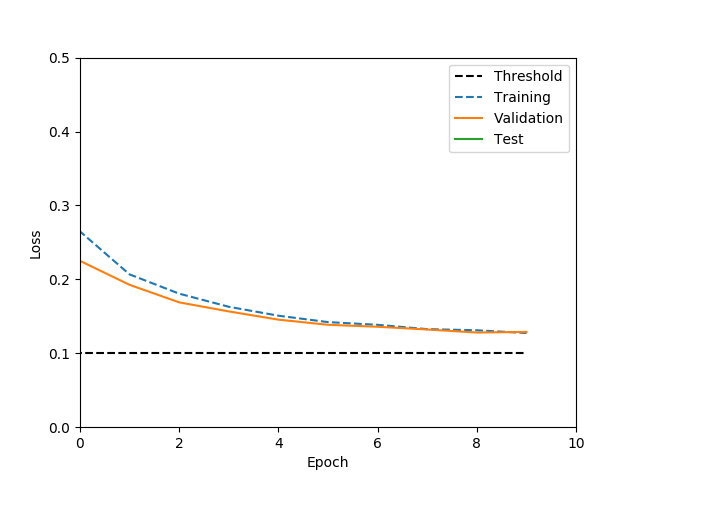

In [29]:
from torch.utils.data import DataLoader, random_split
import torch.optim as optim

recordings_ids = [recording_id for recording_id in callhome1_segments_cut]

train_dataset = Recordings_dataset(callhome1_segments_cut, recordings_ids)

train_length = int(len(train_dataset) * 0.7)
valid_length = len(train_dataset) - train_length

train_dataset, valid_dataset = random_split(train_dataset, [train_length, valid_length])

train_dataloader = DataLoader(train_dataset, batch_size = 16, shuffle=True, num_workers = 8)
valid_dataloader = DataLoader(valid_dataset, batch_size = 16, num_workers = 8)

net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr = 0.0001)

epochs = 10
validation_threshold = 0.1

live_graph = Live_graph(validation_threshold)

for epoch in range(epochs):
    train_losses = []
    for input, target, weigth in train_dataloader:
        input = [tensor.to(device, non_blocking = True).float() for tensor in input]
        target = target.to(device, non_blocking = True).float()
        weigth = weigth.to(device, non_blocking = True).float()

        criterion = nn.BCELoss(weigth)
        net.zero_grad()
        output = net(input)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.data)
        print('train: ' + str(len(train_losses)) + '/' + str(len(train_dataloader)) + '     ', end = '\r')
    train_loss = np.sum(train_losses) / len(train_losses)
    
    with torch.no_grad():
        validation_losses = []
        for input, target, weigth in valid_dataloader:
            input = [tensor.to(device, non_blocking = True).float() for tensor in input]
            target = target.to(device, non_blocking = True).float()
            weigth = weigth.to(device, non_blocking = True).float()

            criterion = nn.BCELoss(weigth)
            output = net(input)
            loss = criterion(output, target)
            validation_losses.append(loss.data)
            print('validation: ' + str(len(validation_losses)) + '/' + str(len(valid_dataloader)) + '     ', end = '\r')
        validation_loss = np.sum(validation_losses) / len(validation_losses)
    
    live_graph.step(train_loss, validation_loss, -1)

    if validation_loss <= validation_threshold:
        print('Done training.')
        break

In [75]:
def test_accuracy(net, dataset):
    dataloader = DataLoader(dataset, batch_size = 1, num_workers = 1)
    dataloader_count = 0
    test_correct = 0
    test_count = 0
    with torch.no_grad():
        for input, target, weigth in dataloader:
            input = [tensor.to(device, non_blocking = True).float() for tensor in input]
            target = target.to(device, non_blocking = True).float()
            weigth = weigth.to(device, non_blocking = True).float()
            output = net(input)
            dataloader_count += 1
            if torch.sum(target) != 0:
                test_count += 1
                if target.max(1)[1] == output.max(1)[1]:
                    test_correct += 1
                print('test: ' + str(dataloader_count) + '/' + str(len(dataloader)) + ' accuracy: ' + str(test_correct / test_count), end = '\r')
    return test_correct / test_count

In [88]:
def test_diarization(net, recordings_segments, recordings_ids):
    results = {}
    results_reduced = {}
    for recording_id in recordings_ids:
        # Getting the speaker's models
        recording_dataset = Recordings_dataset(recordings_segments, recording_id)
        speakers_models = recording_dataset.recordings_data[recording_id]['speakers_models']
        speakers_models = [speakers_models[speaker_id][0] for speaker_id in speakers_models]
        #speakers_models.append(np.random.uniform(-0.1, 0.1, 128))
        #speakers_models = [np.random.uniform(-0.1, 0.1, 128)] + (speakers_models)
        #speakers_models = [speakers_models[1]] + [np.random.uniform(-0.1, 0.1, 128)] + [speakers_models[0]]
        # At this point there is no information about the speaker identity, only the model
        results[recording_id] = []
        for segment in recordings_segments[recording_id]:
            vector = np.asarray(segment[conf_vector][0]['value'])
            with torch.no_grad():
                input = [torch.Tensor([nparray]).to(device, non_blocking = True).float() for nparray in [vector] + speakers_models]
                output = net(input)
                index = output.max(1)[1].cpu().data.numpy()[0]
                #print(output, index)
                results[recording_id].append({ 'begining': segment['begining'], 'ending': segment['ending'], 'speaker_id': index })
                if len(results[recording_id]) > 2:
                    if results[recording_id][len(results[recording_id]) - 1]['speaker_id'] == results[recording_id][len(results[recording_id]) - 3]['speaker_id']:
                        if results[recording_id][len(results[recording_id]) - 1]['speaker_id'] != results[recording_id][len(results[recording_id]) - 2]['speaker_id']:
                            results[recording_id][len(results[recording_id]) - 2]['speaker_id'] = results[recording_id][len(results[recording_id]) - 1]['speaker_id']
                            results[recording_id][len(results[recording_id]) - 1]['modified'] = True
        results_reduced[recording_id] = []
        last_speaker_id = -1
        last_speaker = { 'begining': 0, 'ending': 0, 'speaker_id': -1 }
        for segment in results[recording_id] + [{ 'begining': 0, 'ending': 0, 'speaker_id': -1 }]:
            begining = segment['begining']
            ending = segment['ending']
            speaker_id = segment['speaker_id']
            if last_speaker_id != speaker_id:
                if last_speaker_id != -1:
                    results_reduced[recording_id].append(last_speaker)
                last_speaker_id = speaker_id
                last_speaker = { 'begining': begining, 'ending': ending, 'speaker_id': speaker_id }
            else:
                if begining <= last_speaker['ending']:
                    last_speaker['ending'] = ending
                else:
                    if last_speaker_id != -1:
                        results_reduced[recording_id].append(last_speaker)
                    last_speaker_id = speaker_id
                    last_speaker = { 'begining': begining, 'ending': ending, 'speaker_id': speaker_id }
        results_rttm = ''
        for recording_id in results_reduced:
            for segment in results_reduced[recording_id]:
                result_rttm = 'SPEAKER ' + recording_id + ' 0 ' + str(segment['begining']) + ' ' + str(round(segment['ending'] - segment['begining'], 2)) + ' <NA> <NA> ' + str(segment['speaker_id']) + ' <NA> <NA>'
                results_rttm += result_rttm + '\n'
                        

    groundtruth_rttm_filepath = '../callhome2_1.0_0.5.rttm'
    file = open(groundtruth_rttm_filepath, 'r')
    groundtruth_rttm = ''.join([line for line in file.readlines() if (line.split(' ')[1] in recordings_ids) and \
                    (line.split(' ')[7] in ['A', 'B'])])
    file.close()

    file = open('test_results.rttm', 'w')
    file.write(results_rttm)
    file.close()

    file = open('test_groundtruth.rttm', 'w')
    file.write(groundtruth_rttm)
    file.close()
    
    return md_eval('test_groundtruth.rttm', 'test_results.rttm')

In [89]:
c2_recordings_ids = [recording_id for recording_id in callhome2_segments_cut]
c2_recordings_ids.sort()
#test_accuracy(net, Recordings_dataset(callhome2_segments, c2_recordings_ids))
print(test_diarization(net, callhome2_segments, c2_recordings_ids))

12.98
